In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from typing import Tuple, Optional
from torch import Tensor
import rnn

import glob
import os

In [3]:
from subhalo_impact import chi_eval, initial_stream
from rotation_matrix import obs_from_pos6d

In [3]:
def replace_with_neighboring_value(values, values_stats, empty_bin_indices, phi1, phi1_edges):
    values_stats = np.copy(values_stats)
    for i in empty_bin_indices:
        neighboring_bin1 = i-1
        neighboring_bin2 = i+1
        
        while neighboring_bin1 in empty_bin_indices:
            neighboring_bin1 -= 1
        
        while neighboring_bin2 in empty_bin_indices:
                neighboring_bin2 += 1
        
        median, _, _ = scipy.stats.binned_statistic(phi1, values, statistic='median', bins = 1, range = (phi1_edges[neighboring_bin1], phi1_edges[neighboring_bin2+1]))
        values_stats[i] = median[0]
    return values_stats

In [4]:
def replace_with_neighboring_value_std(std_stats, empty_bin_indices):
    std_stats = np.copy(std_stats)
    for i in empty_bin_indices:
        neighboring_bin1 = i-1
        neighboring_bin2 = i+1
        
        while neighboring_bin1 in empty_bin_indices:
            neighboring_bin1 -= 1
        
        while neighboring_bin2 in empty_bin_indices:
                neighboring_bin2 += 1
        
        std_stats[i] = np.median([std_stats[neighboring_bin1], std_stats[neighboring_bin2]])
    return std_stats

In [5]:
def check_existing_file(pid):
    '''
    this function read through a list of files (final coords) to see if log_Msat, vz matches any, 
    if already exist, return true
    '''

    os.chdir(r'/Users/rutongpei/Documents/GitHub/SBI-streameeeee/sims/final_stream')
    my_files = glob.glob('*.txt')

    for txtfile in my_files:
        if str(pid) in txtfile:
            return True

    return False

    

In [6]:
def calculate_pid(log_Msat,vz):
    pid = 0
    log_Msat_round = round(log_Msat, 2)
    vz_round = round(vz,1)
    if log_Msat_round >= 0:
        pid = log_Msat_round * 1e6
    else: 
        pid = abs(log_Msat_round) * 1e6 + 1e7
    if  vz_round >= 0: 
        pid += vz_round * 10
    else:
        pid += abs(vz_round) * 10 + 1e3
    return int(pid)

In [7]:
def calculate_summary_statistics(phi1,phi2,dist,pm1,pm2,vr,bins):
    '''to include in the output:
        phi1 edges
        fraction = count / len(phi1)
        phi2 median
        vr median

        phi2 std
        vr std
    '''
    phi2_median, phi1_edges, _ = scipy.stats.binned_statistic(phi1, phi2, statistic='median', bins = bins)
    phi2_std, _, _ = scipy.stats.binned_statistic(phi1, phi2, statistic='std', bins = bins)
    count, _, _ = scipy.stats.binned_statistic(phi1, phi2, statistic='count', bins = bins)
    vr_median, _, _ = scipy.stats.binned_statistic(phi1, vr, statistic='median', bins = bins)
    vr_std, _, _ = scipy.stats.binned_statistic(phi1, vr, statistic='std', bins = bins)

    '''fill in empty bins with neighboring values'''
    nan_indices = np.argwhere(np.isnan(phi2_median)).flatten()
    phi2_median_new = replace_with_neighboring_value(phi2, phi2_median, nan_indices, phi1, phi1_edges)
    vr_median_new = replace_with_neighboring_value(vr, vr_median, nan_indices, phi1, phi1_edges)

    phi2_std_new = replace_with_neighboring_value_std(phi2_std, nan_indices)
    vr_std_new = replace_with_neighboring_value_std(vr_std, nan_indices)

    output = np.vstack((phi1_edges[:-1], phi2_median_new, count/len(phi1), vr_median_new, phi2_std_new, vr_std_new))
    output = torch.from_numpy(output)

    return output
    

In [42]:
def load_stream_data(pid):
    data = np.genfromtxt(f'/Users/rutongpei/Documents/GitHub/SBI-streameeeee/sims/final_stream/final_stream_{pid}.txt')
    R_phi12_radec = np.array([[0.83697865, 0.29481904, -0.4610298], 
                          [0.51616778, -0.70514011, 0.4861566], 
                          [0.18176238, 0.64487142, 0.74236331]])
    return obs_from_pos6d(data[:,:3],data[:,3:6],R_phi12_radec)
    

In [9]:
def simulator (params, scatter = 0.1, bins = 100):
    params = np.array(params, dtype=float) # convert tensor to np ndarray
    log_Msat = params[0]
    M_sat = 10**log_Msat
    vz = params[1]
    # r = params[2]

    pid = calculate_pid(log_Msat, vz)
    r = 0.2
    phi = 250 # angle around stream in dec
    vphi = 35  # velocity around stream in km/s
    t_a = 0.2 # time since interaction in Gyr
    phi_a = -4 # interaction point along stream in deg, phi=0 is progenitor location (try -20 to 10)
    rs_sat = 1.05 * (M_sat*10*10)**0.5 # scale radius of subhalo in kpc, can be adjusted along with M_sat using equation 15 in erkal et al. 2015
    tmax=4 # how long stream disrupts in Gyr

    chi_eval(r,phi,vphi,vz,M_sat,tmax,t_a,phi_a,rs_sat,pid)
    
    phi1,phi2,dist,pm1,pm2,vr = load_stream_data(pid)

    output = calculate_summary_statistics(phi1,phi2,dist,pm1,pm2,vr,bins)
    
    return (output+ torch.randn_like(output) * scatter).T

In [43]:
def load_without_rerun(num_simulation = 10):
    '''
    load num_sim number of simulation stats from existing txt files,
    parameters log_Msat 2 decimal & vz 1 decimal
    
    return theta, x
    (theta: shape of num_sim x parameter)
    (x: shape of num_sim x summary_stats)
    '''

    os.chdir(r'/Users/rutongpei/Documents/GitHub/SBI-streameeeee/sims/final_stream')
    my_files = glob.glob('*.txt')
    batch_size = min(len(my_files), num_simulation)

    theta = torch.zeros(batch_size, 2)
    x = torch.zeros(batch_size, 100, 6)

    i = 0
    for txtfile in my_files:
        pid = txtfile[13:-4]
        pid = int(pid)
        
        phi1,phi2,dist,pm1,pm2,vr = load_stream_data(pid)
        output = calculate_summary_statistics(phi1,phi2,dist,pm1,pm2,vr,100)
        output = (output + torch.randn_like(output) * 0.1).T
        x[i] = output

        log_Msat = 0
        vz = 0
        if pid // 1e7 == 1:
            log_Msat = - ((pid % 1e7) // 1e4) /1e2
        else: 
            log_Msat = pid // 1e4 / 1e2
        if (pid % 1e4) // 1e3 == 1:
            vz = - ((pid % 1e4) % 1e3) / 10
        else: 
            vz = (pid % 1e4) /10
        
        theta[i] = torch.as_tensor([log_Msat, vz])

        i += 1
        if i >= num_simulation: break
    
    os.chdir(r'/Users/rutongpei/Documents/GitHub/SBI-streameeeee/sims')
    return theta, x

In [11]:
# # log M_sat, r, vz
# num_dim = 3

# # need to change to more accurate distributions (range, mean, etc.)
# prior_min = [0.00001, -50, 0]
# prior_max = [10, 0, 30]


num_dim = 2
prior_min = [-5, -50]
prior_max = [1, 0]

prior_uniform = utils.BoxUniform(low = torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

prior_normal = torch.distributions.MultivariateNormal(5 * torch.ones(num_dim), 1 * torch.eye(num_dim))

In [12]:
# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior_uniform)

Setup pid: 10341150 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-14.960186004638672,tapproach=0.2,phiapproach=-4,pid=10341150
Orbit pid: 10341150 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-61.503922, vy=28.380910, vz=-58.195105, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  7.081758862124089
Impact pid: 10341150 with M_sat=0.454887, rs_sat=7.081759,  
Sanity check : Initializing potential


In [36]:
# test the embedding net, comment in to run
# define RNN parameters
n_in = 6  # number of input channels
n_out = 2  # number of output channels
num_layers = 2  # number of recurrent layers
hidden_features = 8  # number of hidden features

embedding_net = rnn.EmbeddingNet(n_in, n_out, hidden_features, num_layers)

# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=8)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [14]:
# run the inference procedure on one round and 10000 simulated data points
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=2)

In [35]:
theta, x = load_without_rerun(500)

0
14001290
1
14201200
2
241255
3
14301200
4
12351356
5
10901253
6
12021190
7
12411299
8
14001130
9
14471387
10
12251141
11
14001440
12
11881343
13
851124
14
14421349
15
14521375
16
10311268
17
13911459
18
13501200
19
14001050
20
13401200
21
851442
22
10101200
23
11091260
24
14001250
25
14171006
26
14501070
27
13791454
28
10121265
29
14001330
30
13161463
31
14801200
32
14901200
33
11841005
34
12771266
35
14091290
36
13701457
37
14261125
38
11141487
39
10591220
40
11221491
41
12221328
42
11401095
43
10471101
44
14001480
45
11261274
46
461243
47
14211011
48
12601353
49
12761302
50
10301285
51
14001090
52
11701415
53
13721143
54
10551164
55
10961402
56
11451249
57
13321415
58
14001080
59
421065
60
10391484
61
13411438
62
12001050
63
14001490
64
14121026
65
13541025
66
11871316
67
10271174
68
11501287
69
581172
70
10421243
71
14391204
72
11971465
73
12201200
74
12301200
75
451193
76
11581323
77
14331298
78
10841328
79
12191456
80
14001320
81
12291363
82
14921077
83
191236
84
981129
85
11661

In [44]:
print(x.shape)
print(theta.shape)

torch.Size([491, 100, 6])
torch.Size([491, 2])


In [37]:
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 88 epochs.

In [ ]:
# posterior = infer(simulator, prior_uniform, "SNPE", num_simulations=1)

In [38]:
true_parameter1 = torch.tensor([-4.5, -20])
true_parameter2 = torch.tensor([0.8, -48])
true_parameter3 = torch.tensor([-3, -30])
true_parameter4 = torch.tensor([-2, -5])
true_parameter5 = torch.tensor([0.1, -28])
true_parameter6 = torch.tensor([-1.2, -37])
true_parameter7 = torch.tensor([-2.7, -11])

In [39]:
observation1 = simulator(true_parameter1)
observation2 = simulator(true_parameter2)
observation3 = simulator(true_parameter3)
observation4 = simulator(true_parameter4)
observation5 = simulator(true_parameter5)
observation6 = simulator(true_parameter6)
observation7 = simulator(true_parameter7)

Setup pid: 14501200 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-20.0,tapproach=0.2,phiapproach=-4,pid=14501200
Orbit pid: 14501200 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-59.608256, vy=25.286811, vz=-54.697573, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.05904583914498666
Impact pid: 14501200 with M_sat=0.000032, rs_sat=0.059046,  
Sanity check : Initializing potential
14501200
Setup pid: 801480 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-48.0,tapproach=0.2,phiapproach=-4,pid=801480
Orbit pid: 801480 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-49.076390, vy=8.096742, vz=-35.266122, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  26.374807892831

In [40]:
posterior_samples_1 = posterior.sample((100000,), x=observation1)
posterior_samples_2 = posterior.sample((100000,), x=observation2)
posterior_samples_3 = posterior.sample((100000,), x=observation3)
posterior_samples_4 = posterior.sample((100000,), x=observation4)
posterior_samples_5 = posterior.sample((100000,), x=observation5)
posterior_samples_6 = posterior.sample((100000,), x=observation6)
posterior_samples_7 = posterior.sample((100000,), x=observation7)

Drawing 100000 posterior samples: 100154it [00:00, 202674.39it/s]                           
Drawing 100000 posterior samples: 101400it [00:00, 218392.76it/s]                           
Drawing 100000 posterior samples: 102282it [00:00, 301696.24it/s]                           
Drawing 100000 posterior samples: 101806it [00:00, 344913.49it/s]                           
Drawing 100000 posterior samples: 100740it [00:00, 329342.46it/s]                           
Drawing 100000 posterior samples: 102382it [00:00, 339068.07it/s]                           
Drawing 100000 posterior samples: 101265it [00:00, 321980.11it/s]                           


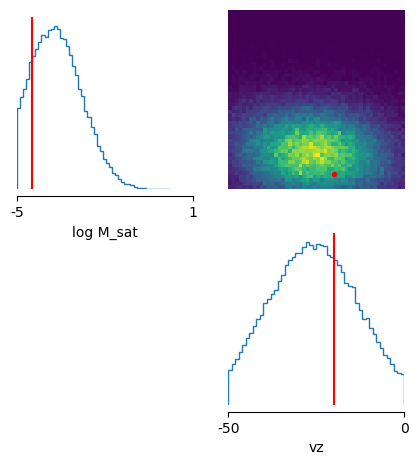

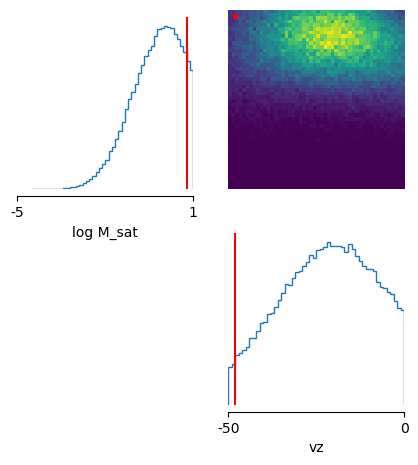

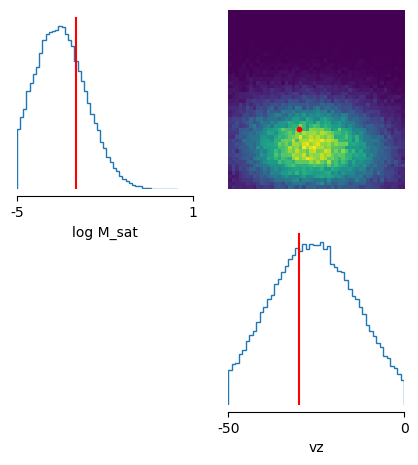

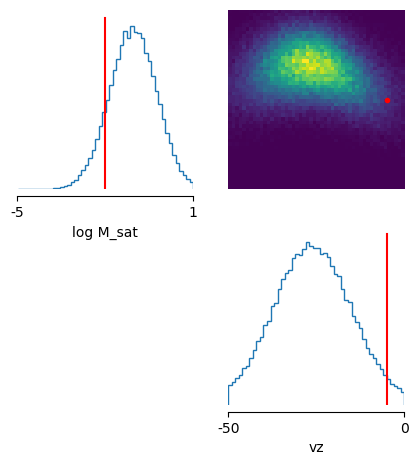

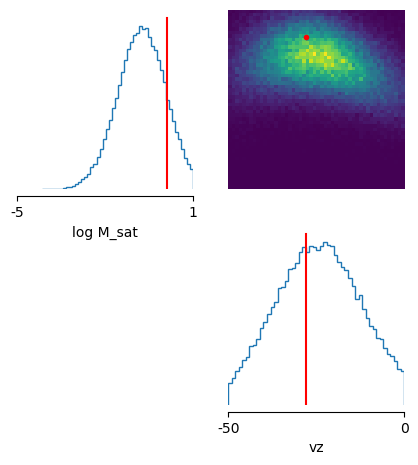

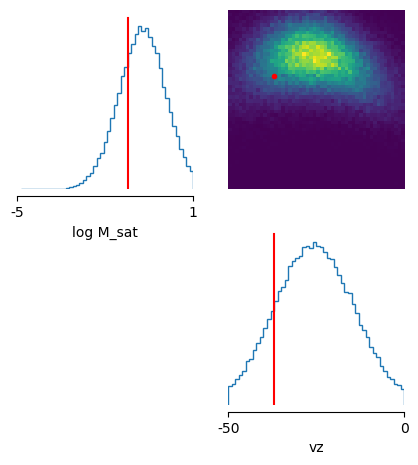

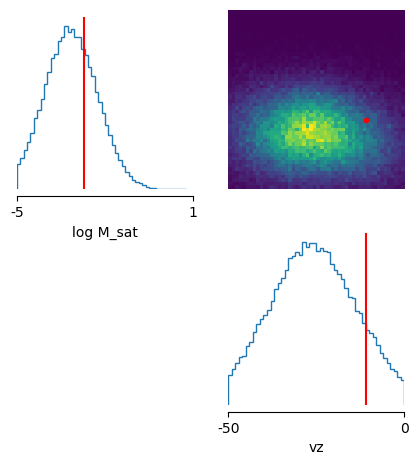

In [41]:
_ = analysis.pairplot(
    posterior_samples_1, limits = [[-5,1], [-50, 0]],
    ticks = [[-5,1], [-50, 0]],
    figsize = (5, 5),
    points = true_parameter1,
    points_offdiag = {"markersize": 6},
    points_colors = "r",
    labels = ["log M_sat","vz"]
)

_ = analysis.pairplot(
    posterior_samples_2, limits = [[-5,1], [-50, 0]],
    ticks = [[-5,1], [-50, 0]],
    figsize = (5, 5),
    points = true_parameter2,
    points_offdiag = {"markersize": 6},
    points_colors = "r",
    labels = ["log M_sat","vz"]
)
_ = analysis.pairplot(
    posterior_samples_3, limits = [[-5,1], [-50, 0]],
    ticks = [[-5,1], [-50, 0]],
    figsize = (5, 5),
    points = true_parameter3,
    points_offdiag = {"markersize": 6},
    points_colors = "r",
    labels = ["log M_sat","vz"]
)
_ = analysis.pairplot(
    posterior_samples_4, limits = [[-5,1], [-50, 0]],
    ticks = [[-5,1], [-50, 0]],
    figsize = (5, 5),
    points = true_parameter4,
    points_offdiag = {"markersize": 6},
    points_colors = "r",
    labels = ["log M_sat","vz"]
)
_ = analysis.pairplot(
    posterior_samples_5, limits = [[-5,1], [-50, 0]],
    ticks = [[-5,1], [-50, 0]],
    figsize = (5, 5),
    points = true_parameter5,
    points_offdiag = {"markersize": 6},
    points_colors = "r",
    labels = ["log M_sat","vz"]
)
_ = analysis.pairplot(
    posterior_samples_6, limits = [[-5,1], [-50, 0]],
    ticks = [[-5,1], [-50, 0]],
    figsize = (5, 5),
    points = true_parameter6,
    points_offdiag = {"markersize": 6},
    points_colors = "r",
    labels = ["log M_sat","vz"]
)
_ = analysis.pairplot(
    posterior_samples_7, limits = [[-5,1], [-50, 0]],
    ticks = [[-5,1], [-50, 0]],
    figsize = (5, 5),
    points = true_parameter7,
    points_offdiag = {"markersize": 6},
    points_colors = "r",
    labels = ["log M_sat","vz"]
)

In [22]:
def hpd(trace, mass_frac):
    ''' 
    Returns highest probability density region given by a set of samples.

    Parameters
    ----------
    trace: array
        1D array of MCMC samples for a single variable
    mass_frac: float with 0 < mass_frac <= 1
        The fraction of the probability to be included in the HPD. For example, 'massfrac'=0.95 gives a 95% HPD.

    Returns
    -------
    output: array, shape(2,)
        The bounds of the HPD
    '''

    # Get sorted list
    d = np.sort(np.copy(trace))

    # Number of total samples taken
    n = len(trace)

    # Get number of samples that should be included in HPD
    n_samples = np.floor(mass_frac * n).astype(int)

    # Get width (in units of data) of all intervals with n_samples samples
    int_width = d[n_samples:] - d[:n-n_samples]

    # Pick out minimal interval
    min_int = np.argmin(int_width)

    # Return interval
    return np.array([d[min_int], d[min_int+n_samples]])

In [30]:
# simple version

def coverage_plot_data(simulator, posterior, true_values):
    fractions = np.array([])
    x = np.arange(0, 1, 0.1)

    samples = [[0] for _ in range(len(true_values))]
    for i in range(len(true_values)):
        simulated_samples = posterior.sample((1000,), x = simulator(torch.as_tensor([-4, true_values[i]])))[:,1]
        samples[i] = np.array(simulated_samples)
    
    for confidence in x:
        contain_true = 0
        for i in range(len(true_values)):
            lower, upper = hpd(samples[i],confidence)
            if lower <= true_values[i] <= upper:
                contain_true += 1
        fractions = np.append(fractions, [contain_true/len(true_values)])
    return x, fractions

In [31]:
def draw_coverage_plot_1d(x, fractions, variable):
    plt.plot(x, fractions, label = 'model coverage')
    plt.plot([0,1],[0,1],color='r', label = 'perfect coverage')
    plt.ylim(0,1)
    plt.title(f"coverage for {variable}")
    plt.xlabel("confidence interval")
    plt.ylabel("covereage percentage")
    plt.show()

In [32]:
true_values = np.arange(-50, 0, 1)
x, factions = coverage_plot_data(simulator, posterior, true_values)

Setup pid: 14001500 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-50.0,tapproach=0.2,phiapproach=-4,pid=14001500
Orbit pid: 14001500 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-48.324114, vy=6.868879, vz=-33.878161, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001500 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001500


Drawing 1000 posterior samples: 1075it [00:00, 8919.02it/s]                         


Setup pid: 14001490 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-49.0,tapproach=0.2,phiapproach=-4,pid=14001490
Orbit pid: 14001490 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-48.700252, vy=7.482810, vz=-34.572141, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001490 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001490


Drawing 1000 posterior samples: 1107it [00:00, 54483.63it/s]            


Setup pid: 14001480 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-48.0,tapproach=0.2,phiapproach=-4,pid=14001480
Orbit pid: 14001480 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-49.076390, vy=8.096742, vz=-35.266122, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001480 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001480


Drawing 1000 posterior samples: 1167it [00:00, 52458.58it/s]            


Setup pid: 14001470 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-47.0,tapproach=0.2,phiapproach=-4,pid=14001470
Orbit pid: 14001470 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-49.452528, vy=8.710673, vz=-35.960102, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001470 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001470


Drawing 1000 posterior samples: 1104it [00:00, 47691.02it/s]            


Setup pid: 14001460 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-46.0,tapproach=0.2,phiapproach=-4,pid=14001460
Orbit pid: 14001460 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-49.828666, vy=9.324604, vz=-36.654083, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001460 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001460


Drawing 1000 posterior samples: 1092it [00:00, 54346.74it/s]            


Setup pid: 14001450 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-45.0,tapproach=0.2,phiapproach=-4,pid=14001450
Orbit pid: 14001450 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-50.204804, vy=9.938535, vz=-37.348063, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001450 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001450


Drawing 1000 posterior samples: 1083it [00:00, 42980.04it/s]            


Setup pid: 14001440 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-44.0,tapproach=0.2,phiapproach=-4,pid=14001440
Orbit pid: 14001440 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-50.580942, vy=10.552466, vz=-38.042043, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001440 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001440


Drawing 1000 posterior samples: 1089it [00:00, 33260.01it/s]            


Setup pid: 14001430 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-43.0,tapproach=0.2,phiapproach=-4,pid=14001430
Orbit pid: 14001430 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-50.957081, vy=11.166397, vz=-38.736024, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001430 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001430


Drawing 1000 posterior samples: 1086it [00:00, 46144.48it/s]            


Setup pid: 14001420 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-42.0,tapproach=0.2,phiapproach=-4,pid=14001420
Orbit pid: 14001420 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-51.333219, vy=11.780328, vz=-39.430004, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001420 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001420


Drawing 1000 posterior samples: 1074it [00:00, 32824.11it/s]            


Setup pid: 14001410 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-41.0,tapproach=0.2,phiapproach=-4,pid=14001410
Orbit pid: 14001410 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-51.709357, vy=12.394259, vz=-40.123985, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001410 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001410


Drawing 1000 posterior samples: 1083it [00:00, 47900.78it/s]            


Setup pid: 14001400 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-40.0,tapproach=0.2,phiapproach=-4,pid=14001400
Orbit pid: 14001400 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-52.085495, vy=13.008190, vz=-40.817965, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001400 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001400


Drawing 1000 posterior samples: 1093it [00:00, 50842.59it/s]            


Setup pid: 14001390 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-39.0,tapproach=0.2,phiapproach=-4,pid=14001390
Orbit pid: 14001390 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-52.461633, vy=13.622121, vz=-41.511945, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001390 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001390


Drawing 1000 posterior samples: 1086it [00:00, 52733.50it/s]            


Setup pid: 14001380 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-38.0,tapproach=0.2,phiapproach=-4,pid=14001380
Orbit pid: 14001380 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-52.837771, vy=14.236052, vz=-42.205926, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001380 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001380


Drawing 1000 posterior samples: 1102it [00:00, 43850.25it/s]            


Setup pid: 14001370 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-37.0,tapproach=0.2,phiapproach=-4,pid=14001370
Orbit pid: 14001370 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-53.213909, vy=14.849983, vz=-42.899906, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001370 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001370


Drawing 1000 posterior samples: 1130it [00:00, 50262.61it/s]            


Setup pid: 14001360 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-36.0,tapproach=0.2,phiapproach=-4,pid=14001360
Orbit pid: 14001360 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-53.590047, vy=15.463914, vz=-43.593887, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001360 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001360


Drawing 1000 posterior samples: 1073it [00:00, 48746.68it/s]            


Setup pid: 14001350 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-35.0,tapproach=0.2,phiapproach=-4,pid=14001350
Orbit pid: 14001350 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-53.966185, vy=16.077845, vz=-44.287867, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001350 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001350


Drawing 1000 posterior samples: 1040it [00:00, 55113.60it/s]            


Setup pid: 14001340 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-34.0,tapproach=0.2,phiapproach=-4,pid=14001340
Orbit pid: 14001340 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-54.342323, vy=16.691776, vz=-44.981848, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001340 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001340


Drawing 1000 posterior samples: 1073it [00:00, 55243.76it/s]            


Setup pid: 14001330 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-33.0,tapproach=0.2,phiapproach=-4,pid=14001330
Orbit pid: 14001330 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-54.718461, vy=17.305708, vz=-45.675828, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001330 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001330


Drawing 1000 posterior samples: 1194it [00:00, 49746.19it/s]            


Setup pid: 14001320 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-32.0,tapproach=0.2,phiapproach=-4,pid=14001320
Orbit pid: 14001320 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-55.094599, vy=17.919639, vz=-46.369808, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001320 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001320


Drawing 1000 posterior samples: 1060it [00:00, 48935.78it/s]            


Setup pid: 14001310 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-31.0,tapproach=0.2,phiapproach=-4,pid=14001310
Orbit pid: 14001310 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-55.470737, vy=18.533570, vz=-47.063789, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001310 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001310


Drawing 1000 posterior samples: 1081it [00:00, 47310.43it/s]            


Setup pid: 14001300 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-30.0,tapproach=0.2,phiapproach=-4,pid=14001300
Orbit pid: 14001300 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-55.846875, vy=19.147501, vz=-47.757769, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001300 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001300


Drawing 1000 posterior samples: 1088it [00:00, 47579.06it/s]            


Setup pid: 14001290 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-29.0,tapproach=0.2,phiapproach=-4,pid=14001290
Orbit pid: 14001290 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-56.223013, vy=19.761432, vz=-48.451750, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001290 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001290


Drawing 1000 posterior samples: 1106it [00:00, 47494.19it/s]            


Setup pid: 14001280 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-28.0,tapproach=0.2,phiapproach=-4,pid=14001280
Orbit pid: 14001280 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-56.599151, vy=20.375363, vz=-49.145730, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001280 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001280


Drawing 1000 posterior samples: 1105it [00:00, 55053.82it/s]            


Setup pid: 14001270 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-27.0,tapproach=0.2,phiapproach=-4,pid=14001270
Orbit pid: 14001270 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-56.975289, vy=20.989294, vz=-49.839710, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001270 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001270


Drawing 1000 posterior samples: 1112it [00:00, 48205.41it/s]            


Setup pid: 14001260 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-26.0,tapproach=0.2,phiapproach=-4,pid=14001260
Orbit pid: 14001260 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-57.351427, vy=21.603225, vz=-50.533691, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001260 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001260


Drawing 1000 posterior samples: 1093it [00:00, 47697.75it/s]            


Setup pid: 14001250 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-25.0,tapproach=0.2,phiapproach=-4,pid=14001250
Orbit pid: 14001250 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-57.727566, vy=22.217156, vz=-51.227671, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001250 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001250


Drawing 1000 posterior samples: 1049it [00:00, 56053.72it/s]            


Setup pid: 14001240 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-24.0,tapproach=0.2,phiapproach=-4,pid=14001240
Orbit pid: 14001240 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-58.103704, vy=22.831087, vz=-51.921652, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001240 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001240


Drawing 1000 posterior samples: 1094it [00:00, 49433.00it/s]            


Setup pid: 14001230 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-23.0,tapproach=0.2,phiapproach=-4,pid=14001230
Orbit pid: 14001230 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-58.479842, vy=23.445018, vz=-52.615632, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001230 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001230


Drawing 1000 posterior samples: 1097it [00:00, 30339.20it/s]            


Setup pid: 14001220 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-22.0,tapproach=0.2,phiapproach=-4,pid=14001220
Orbit pid: 14001220 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-58.855980, vy=24.058949, vz=-53.309612, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001220 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001220


Drawing 1000 posterior samples: 1109it [00:00, 47213.59it/s]            


Setup pid: 14001210 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-21.0,tapproach=0.2,phiapproach=-4,pid=14001210
Orbit pid: 14001210 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-59.232118, vy=24.672880, vz=-54.003593, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001210 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001210


Drawing 1000 posterior samples: 1074it [00:00, 55031.12it/s]            


Setup pid: 14001200 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-20.0,tapproach=0.2,phiapproach=-4,pid=14001200
Orbit pid: 14001200 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-59.608256, vy=25.286811, vz=-54.697573, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001200 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001200


Drawing 1000 posterior samples: 1042it [00:00, 49402.20it/s]            


Setup pid: 14001190 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-19.0,tapproach=0.2,phiapproach=-4,pid=14001190
Orbit pid: 14001190 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-59.984394, vy=25.900743, vz=-55.391554, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001190 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001190


Drawing 1000 posterior samples: 1057it [00:00, 53829.93it/s]            


Setup pid: 14001180 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-18.0,tapproach=0.2,phiapproach=-4,pid=14001180
Orbit pid: 14001180 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-60.360532, vy=26.514674, vz=-56.085534, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001180 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001180


Drawing 1000 posterior samples: 1107it [00:00, 57321.45it/s]            


Setup pid: 14001170 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-17.0,tapproach=0.2,phiapproach=-4,pid=14001170
Orbit pid: 14001170 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-60.736670, vy=27.128605, vz=-56.779514, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001170 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001170


Drawing 1000 posterior samples: 1083it [00:00, 53495.12it/s]            


Setup pid: 14001160 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-16.0,tapproach=0.2,phiapproach=-4,pid=14001160
Orbit pid: 14001160 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-61.112808, vy=27.742536, vz=-57.473495, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001160 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001160


Drawing 1000 posterior samples: 1110it [00:00, 52930.69it/s]            


Setup pid: 14001150 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-15.0,tapproach=0.2,phiapproach=-4,pid=14001150
Orbit pid: 14001150 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-61.488946, vy=28.356467, vz=-58.167475, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001150 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001150


Drawing 1000 posterior samples: 1066it [00:00, 55738.61it/s]            


Setup pid: 14001140 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-14.0,tapproach=0.2,phiapproach=-4,pid=14001140
Orbit pid: 14001140 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-61.865084, vy=28.970398, vz=-58.861456, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001140 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001140


Drawing 1000 posterior samples: 1235it [00:00, 51986.81it/s]            


Setup pid: 14001130 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-13.0,tapproach=0.2,phiapproach=-4,pid=14001130
Orbit pid: 14001130 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-62.241222, vy=29.584329, vz=-59.555436, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001130 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001130


Drawing 1000 posterior samples: 1078it [00:00, 48698.49it/s]            


Setup pid: 14001120 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-12.0,tapproach=0.2,phiapproach=-4,pid=14001120
Orbit pid: 14001120 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-62.617360, vy=30.198260, vz=-60.249416, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001120 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001120


Drawing 1000 posterior samples: 1058it [00:00, 48312.74it/s]            


Setup pid: 14001110 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-11.0,tapproach=0.2,phiapproach=-4,pid=14001110
Orbit pid: 14001110 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-62.993498, vy=30.812191, vz=-60.943397, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001110 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001110


Drawing 1000 posterior samples: 1103it [00:00, 55540.69it/s]            


Setup pid: 14001100 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-10.0,tapproach=0.2,phiapproach=-4,pid=14001100
Orbit pid: 14001100 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-63.369636, vy=31.426122, vz=-61.637377, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001100 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001100


Drawing 1000 posterior samples: 1110it [00:00, 49434.35it/s]            


Setup pid: 14001090 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-9.0,tapproach=0.2,phiapproach=-4,pid=14001090
Orbit pid: 14001090 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-63.745774, vy=32.040053, vz=-62.331358, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001090 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001090


Drawing 1000 posterior samples: 1177it [00:00, 45968.93it/s]            


Setup pid: 14001080 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-8.0,tapproach=0.2,phiapproach=-4,pid=14001080
Orbit pid: 14001080 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-64.121912, vy=32.653984, vz=-63.025338, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001080 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001080


Drawing 1000 posterior samples: 1321it [00:00, 51547.40it/s]            


Setup pid: 14001070 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-7.0,tapproach=0.2,phiapproach=-4,pid=14001070
Orbit pid: 14001070 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-64.498051, vy=33.267915, vz=-63.719318, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001070 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001070


Drawing 1000 posterior samples: 1047it [00:00, 54760.16it/s]            


Setup pid: 14001060 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-6.0,tapproach=0.2,phiapproach=-4,pid=14001060
Orbit pid: 14001060 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-64.874189, vy=33.881846, vz=-64.413299, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001060 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001060


Drawing 1000 posterior samples: 1051it [00:00, 57453.22it/s]            


Setup pid: 14001050 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-5.0,tapproach=0.2,phiapproach=-4,pid=14001050
Orbit pid: 14001050 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-65.250327, vy=34.495778, vz=-65.107279, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001050 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001050


Drawing 1000 posterior samples: 1047it [00:00, 48786.15it/s]            


Setup pid: 14001040 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-4.0,tapproach=0.2,phiapproach=-4,pid=14001040
Orbit pid: 14001040 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-65.626465, vy=35.109709, vz=-65.801260, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001040 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001040


Drawing 1000 posterior samples: 1062it [00:00, 48349.59it/s]            


Setup pid: 14001030 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-3.0,tapproach=0.2,phiapproach=-4,pid=14001030
Orbit pid: 14001030 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-66.002603, vy=35.723640, vz=-66.495240, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001030 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001030


Drawing 1000 posterior samples: 1053it [00:00, 48621.18it/s]            


Setup pid: 14001020 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-2.0,tapproach=0.2,phiapproach=-4,pid=14001020
Orbit pid: 14001020 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-66.378741, vy=36.337571, vz=-67.189220, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001020 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001020


Drawing 1000 posterior samples: 1076it [00:00, 48745.69it/s]            


Setup pid: 14001010 with tmax=4.000000, t_approach=0.200000 
Sanity check : Initializing potential
tmax: 3.886260
final_t: 3.886260
diff: 0.000000
Running orbit with r=0.2,phi=250,vphi=35,vz=-1.0,tapproach=0.2,phiapproach=-4,pid=14001010
Orbit pid: 14001010 with x=-13.052411, y=-33.619492, z=-23.715755, vx=-66.754879, vy=36.951502, vz=-67.883201, tmax=0.204642,  
Sanity check : Initializing potential
Impact with scale radius:  0.10500000000000001
Impact pid: 14001010 with M_sat=0.000100, rs_sat=0.105000,  
Sanity check : Initializing potential
14001010


Drawing 1000 posterior samples: 1075it [00:00, 45579.66it/s]            


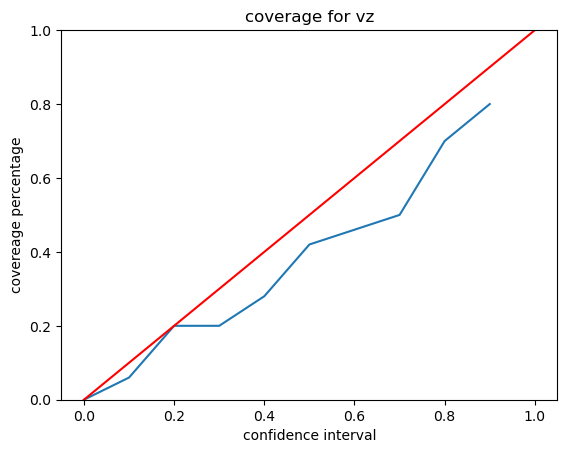

In [34]:
draw_coverage_plot_1d(x, factions, 'vz')